In [1]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.animation import FuncAnimation

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import os
import seaborn as sns
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')
import pims
import pySPM as spm 
import trackpy as tp
import glob
from sxmreader import SXMReader
net_file = '../moire_walk/models/classification_model_30_tmp.h5'

In [2]:
n_range = range(822, 822+5)
N = len(n_range)
SXM_PATH = ["electromigration_29/Image_{0:03}.sxm".format(i) for i in n_range]
frames = SXMReader(SXM_PATH)
molecule_size = 9
detect_kwargs = {
    'minmass' : 2,
    'maxsize' : 4,
    'separation' : 7,
}
f = tp.batch(frames[:], molecule_size, **detect_kwargs)

Frame 4: 12 features


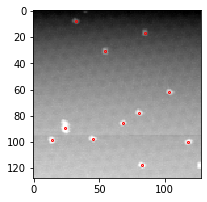

(-0.5, 127.5, 127.5, -0.5)

In [3]:
fig=plt.figure(figsize=(3, 5))
idx = 0
ax = tp.annotate(f[f['frame']==idx], frames[idx], plot_style={'markersize':1})
ax.axis('off')

Frame 4: 12 trajectories present.


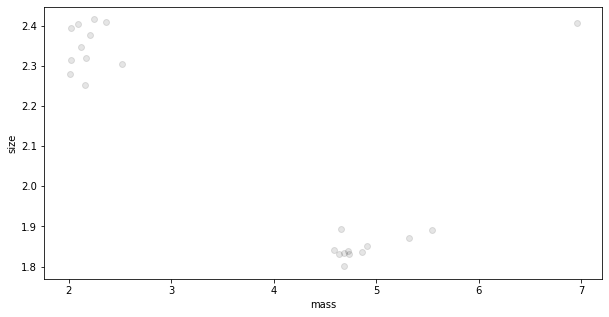

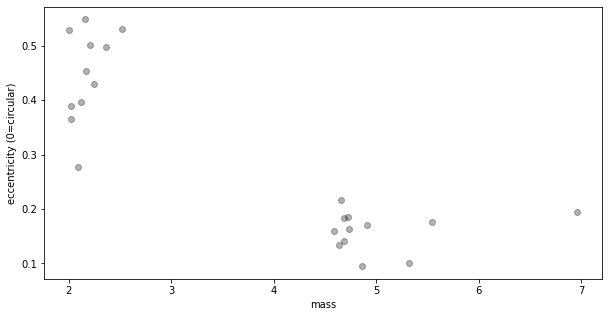

In [4]:
search_kws = {
    'search_range' : 35,
    'adaptive_stop' : 2.0,
    'adaptive_step' : 0.95,
}
t = tp.link(f, **search_kws)
plt.figure()
tp.mass_size(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass
tp.mass_ecc(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass

In [5]:
min_mass, max_mass = 4, 6
min_size, max_size = 1.8, 2.2
min_ecc, max_ecc = 0.1, 0.23
t1 = t[t['ecc'].between(min_ecc, max_ecc) &
       t['size'].between(min_size, max_size) & 
       t['mass'].between(min_mass, max_mass)]
t2 = tp.filter_stubs(t, 5)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t2['particle'].nunique())

Before: 23
After: 11


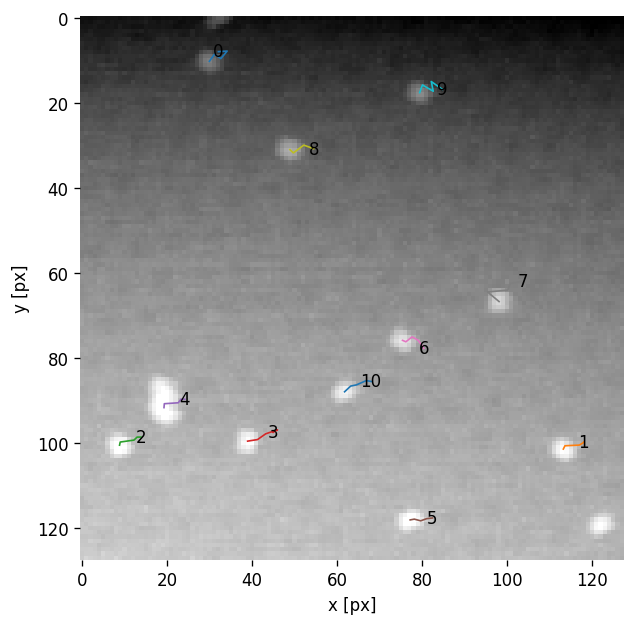

In [6]:
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig=plt.figure(figsize=(8, 6), dpi=120)
ax1=plt.axes(xlim=(0, 256), ylim=(0, 256), frameon=False)
plt.axis('off')
ln, = ax1.plot([], [], lw=3)
ax1.set_prop_cycle(color=['g', 'r', 'c', 'm', 'y', 'k'])
def animate(i):
    plt.cla()
    tp.plot_traj(t2[(t2['frame']<=i)], superimpose=frames[i], label=True, ax=ax1, plot_style={'alpha' : 1})
    ax1.set_prop_cycle(color=['g', 'r', 'c', 'm', 'y', 'k'])
#     plt.imshow(frames[i], cmap='gray')
# Set up formatting for the movie files
Writer = matplotlib.animation.writers['ffmpeg']
writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)
line_ani = matplotlib.animation.FuncAnimation(fig, animate, frames=5)
# line_ani.save('claymation.mp4', writer=writer)
line_ani

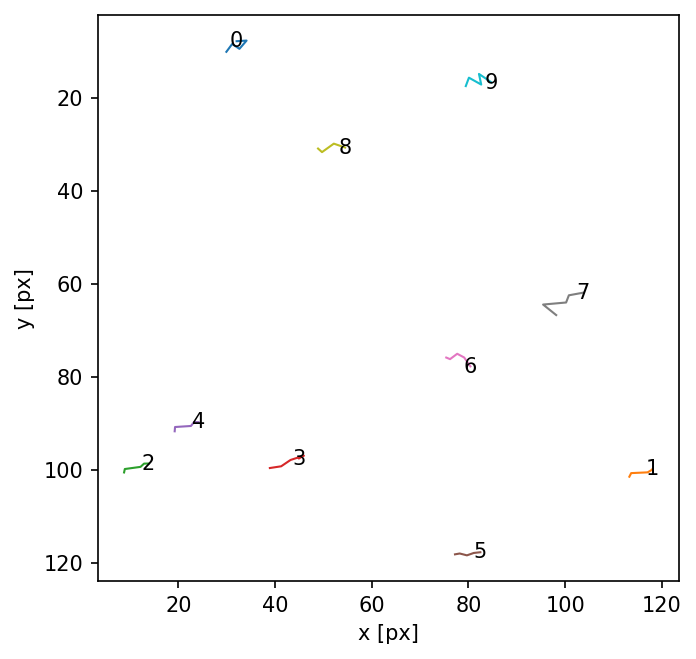

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
t2 = t2[~t2.particle.isin([10])] # 10 is double molecule, 11 is near a defect
tp.plot_traj(t2, label=True)

# MSD

In [8]:
d = tp.compute_drift(t2)
tm = tp.subtract_drift(t2.copy(), d)
tm.head(3)

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
frame,,,,,,,,,,
0,7.884003,32.065327,4.580383,1.746856,0.184768,0.362518,-25.421487,-0.034472,0,0
0,99.826973,118.073731,5.176907,1.804239,0.233380,0.387453,29.440834,0.221102,0,1
0,98.629493,13.827206,4.695468,1.758964,0.103971,0.364436,30.636320,0.190350,0,2


In [9]:
d = tp.compute_drift(t2)
tm = tp.subtract_drift(t2.copy(), d)
t21 = tm.copy()

/home/a/as/asai/dsgo/trading/trading/lib/python3.7/site-packages/trackpy/motion.py:235: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = msds.mul(msds['N'], axis=0).mean(level=1)  # weighted average
/home/a/as/asai/dsgo/trading/trading/lib/python3.7/site-packages/trackpy/motion.py:236: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = results.div(msds['N'].mean(level=1), axis=0)  # weights normalized


(0.0, 25.0)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


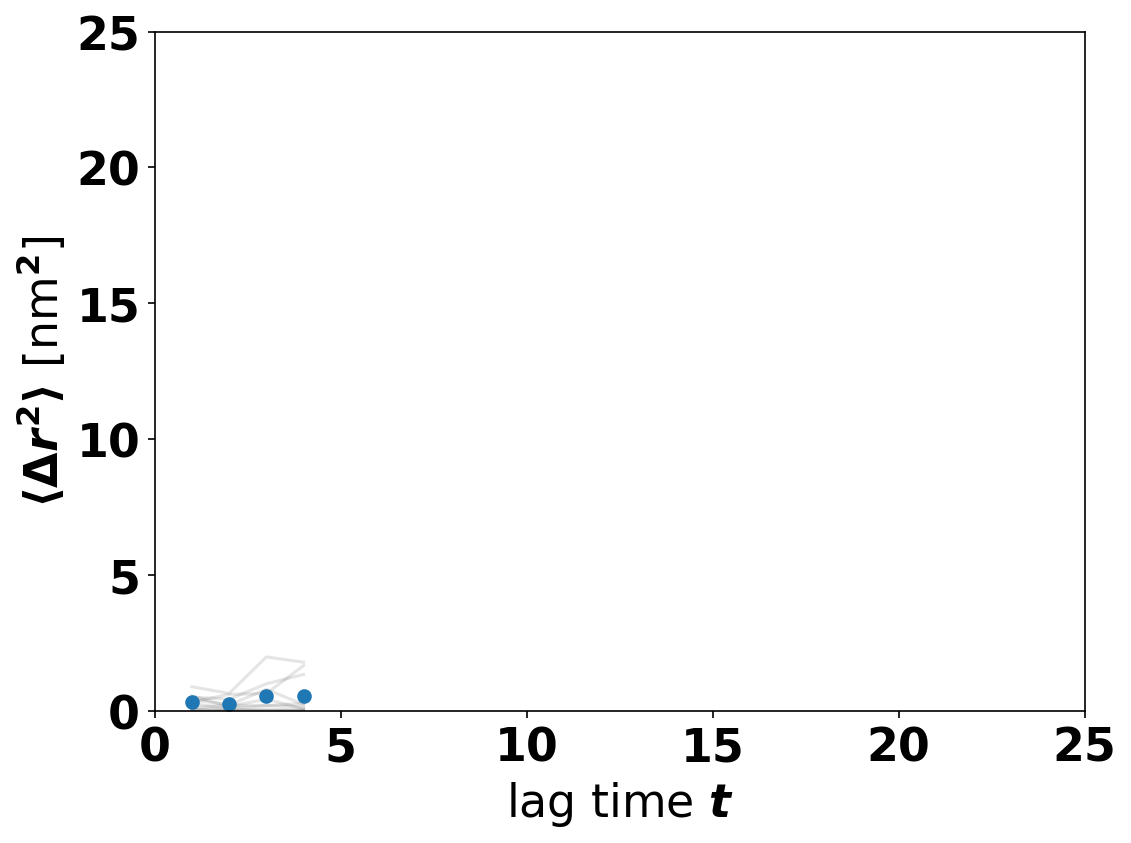

In [10]:
im = tp.imsd(tm, frames.meters_per_pixel * 1e6, 1) * 1e6
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
import matplotlib
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(im.index, im , 'k-', alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [nm$^2$]',
       xlabel='lag time $t$')
# ax.set_xscale('log')
# ax.set_yscale('log')
em = tp.emsd(tm, frames.meters_per_pixel * 1e6, 1) * 1e6
ax.plot(em.index, em, 'o')
ax.set_xlim(0, 25)
ax.set_ylim(0, 25)

## 23K

In [11]:
n_range = range(832, 832+5)
N = len(n_range)
SXM_PATH = ["electromigration_29/Image_{0:03}.sxm".format(i) for i in n_range]
frames = SXMReader(SXM_PATH)
molecule_size = 9
detect_kwargs = {
    'minmass' : 2,
    'maxsize' : 4,
    'separation' : 7,
}
f = tp.batch(frames[:], molecule_size, **detect_kwargs)

Frame 4: 11 features


Frame 4: 11 trajectories present.


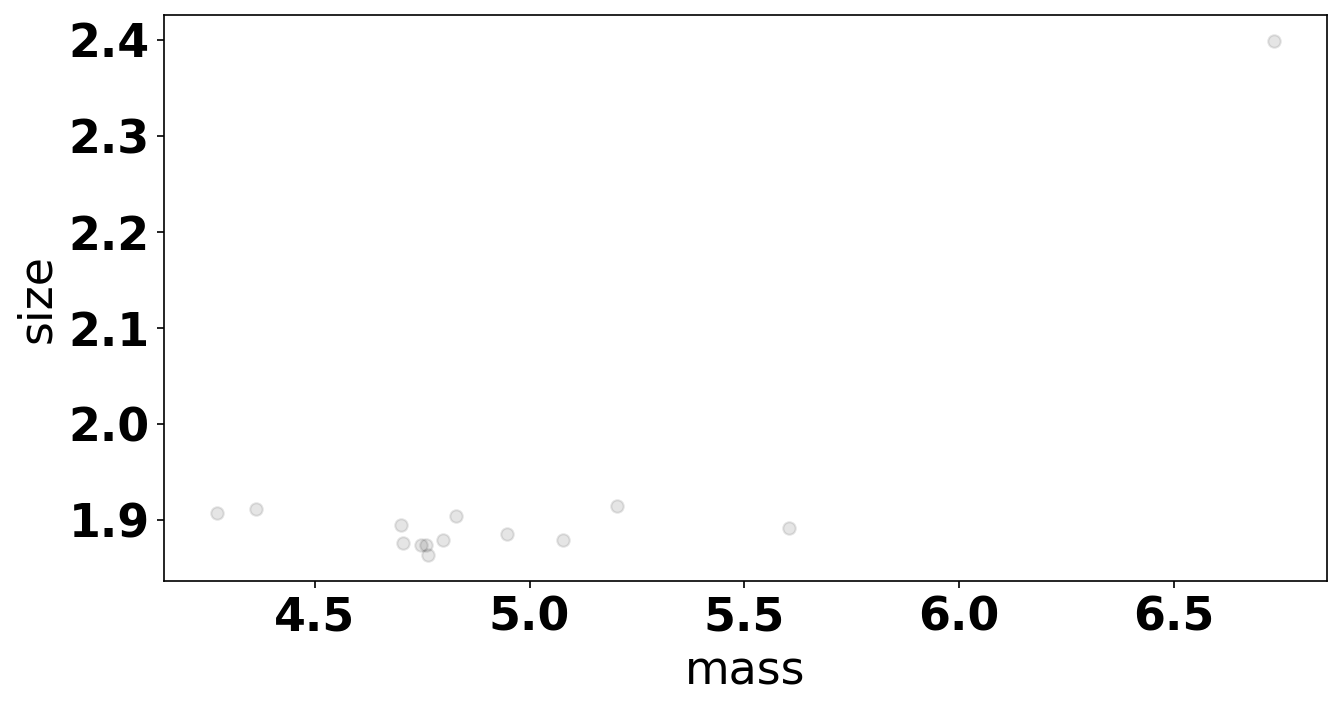

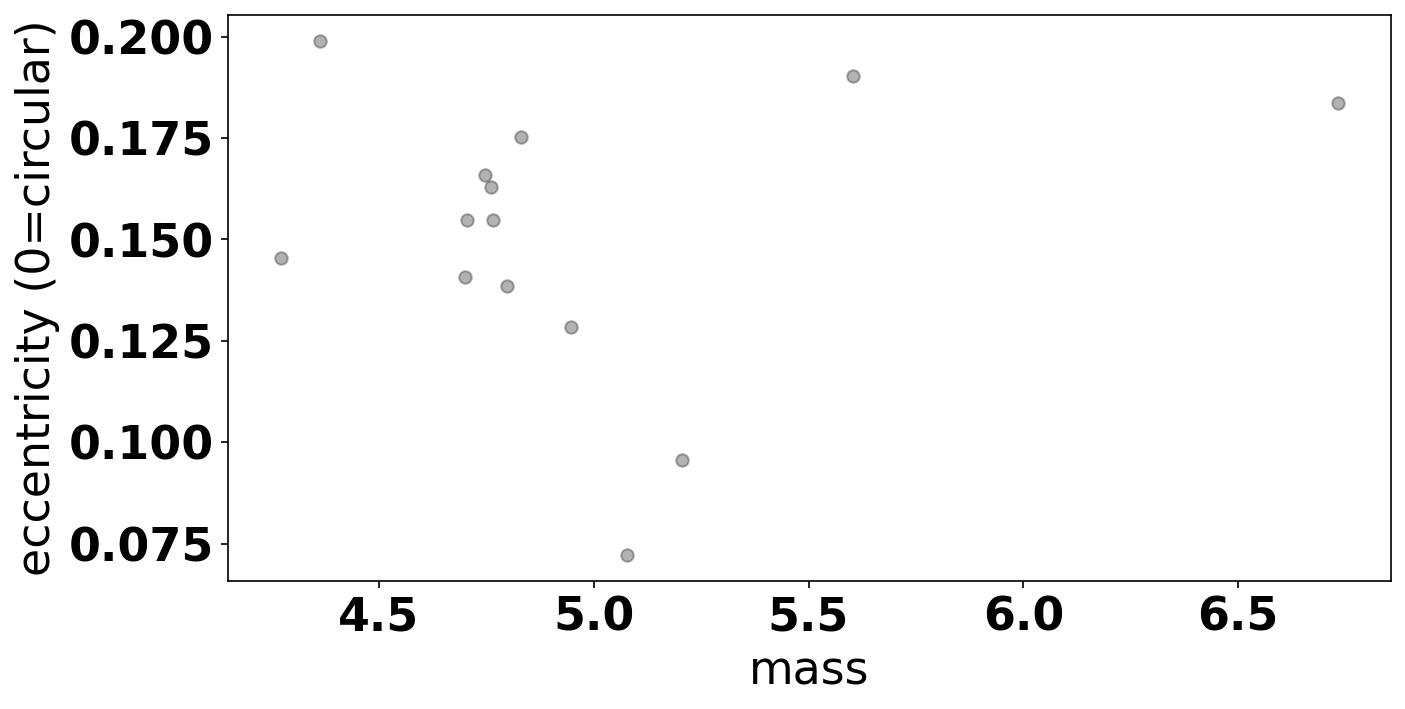

In [12]:
search_kws = {
    'search_range' : 35,
    'adaptive_stop' : 2.0,
    'adaptive_step' : 0.95,
}
t = tp.link(f, **search_kws)
plt.figure()
tp.mass_size(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass
tp.mass_ecc(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass

In [13]:
min_mass, max_mass = 4, 6
min_size, max_size = 1.8, 2.2
min_ecc, max_ecc = 0.1, 0.23
t1 = t[t['ecc'].between(min_ecc, max_ecc) &
       t['size'].between(min_size, max_size) & 
       t['mass'].between(min_mass, max_mass)]
t2 = tp.filter_stubs(t, 5)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t2['particle'].nunique())

Before: 14
After: 11


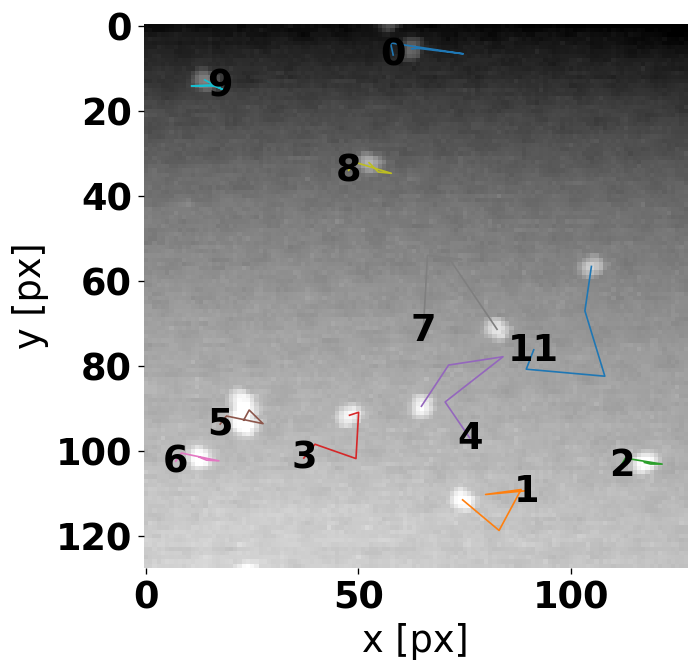

In [14]:
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig=plt.figure(figsize=(8, 6), dpi=120)
ax1=plt.axes(xlim=(0, 256), ylim=(0, 256), frameon=False)
plt.axis('off')
ln, = ax1.plot([], [], lw=3)
ax1.set_prop_cycle(color=['g', 'r', 'c', 'm', 'y', 'k'])
def animate(i):
    plt.cla()
    tp.plot_traj(t2[(t2['frame']<=i)], superimpose=frames[i], label=True, ax=ax1, plot_style={'alpha' : 1})
    ax1.set_prop_cycle(color=['g', 'r', 'c', 'm', 'y', 'k'])
#     plt.imshow(frames[i], cmap='gray')
# Set up formatting for the movie files
Writer = matplotlib.animation.writers['ffmpeg']
writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)
line_ani = matplotlib.animation.FuncAnimation(fig, animate, frames=5)
# line_ani.save('claymation.mp4', writer=writer)
line_ani

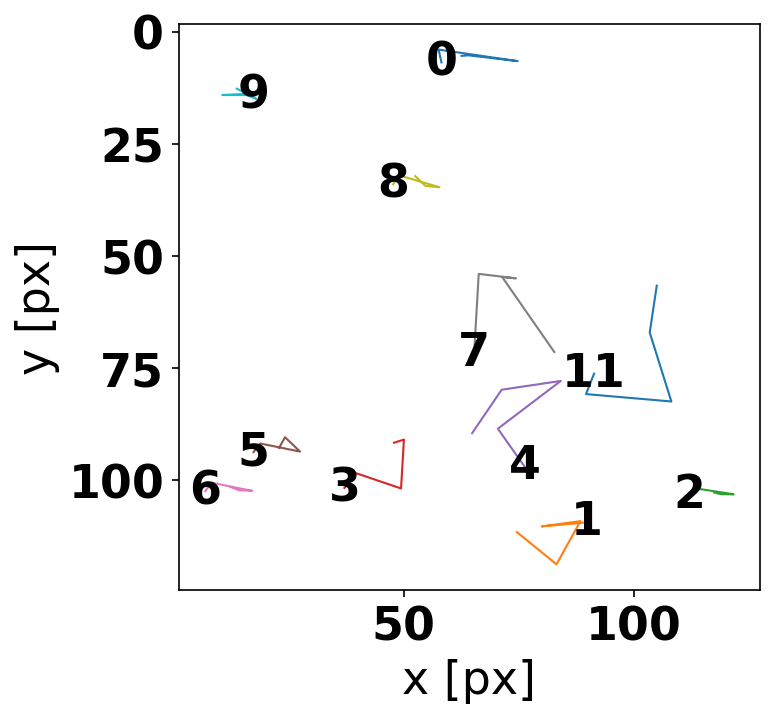

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
t2 = t2[~t2.particle.isin([])] # 10 is double molecule, 11 is near a defect
tp.plot_traj(t2, label=True)

In [16]:
d = tp.compute_drift(t2)
t3 = tp.subtract_drift(t2.copy(), d)
t23 = t3.copy()

## 25K

In [37]:
n_range = range(842, 842+5)
N = len(n_range)
SXM_PATH = ["electromigration_29/Image_{0:03}.sxm".format(i) for i in n_range]
frames = SXMReader(SXM_PATH)
molecule_size = 9
detect_kwargs = {
    'minmass' : 2,
    'maxsize' : 4,
    'separation' : 7,
}
f = tp.batch(frames[:], molecule_size, **detect_kwargs)

Frame 4: 9 features


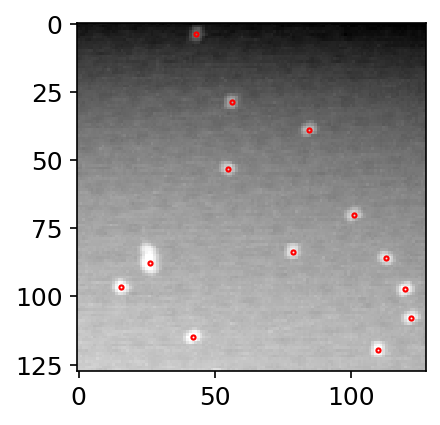

(-0.5, 127.5, 127.5, -0.5)

In [38]:
fig=plt.figure(figsize=(3, 5))
idx = 0
ax = tp.annotate(f[f['frame']==idx], frames[idx], plot_style={'markersize':1})
ax.axis('off')

Frame 4: 9 trajectories present.


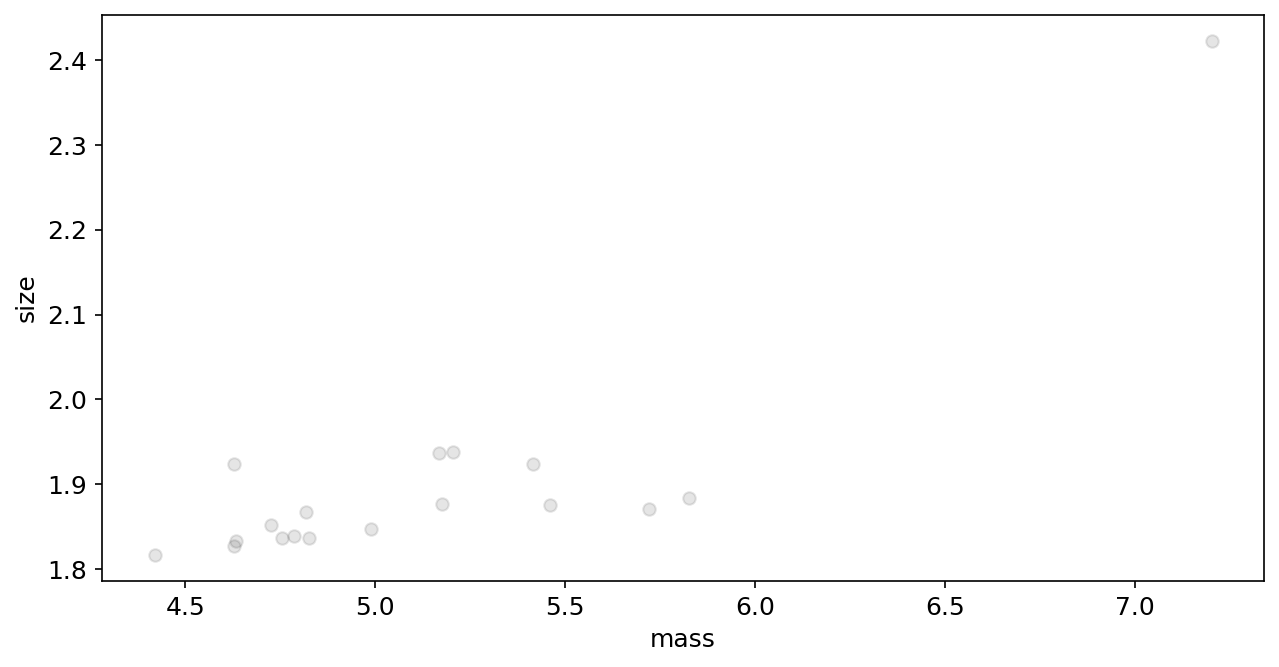

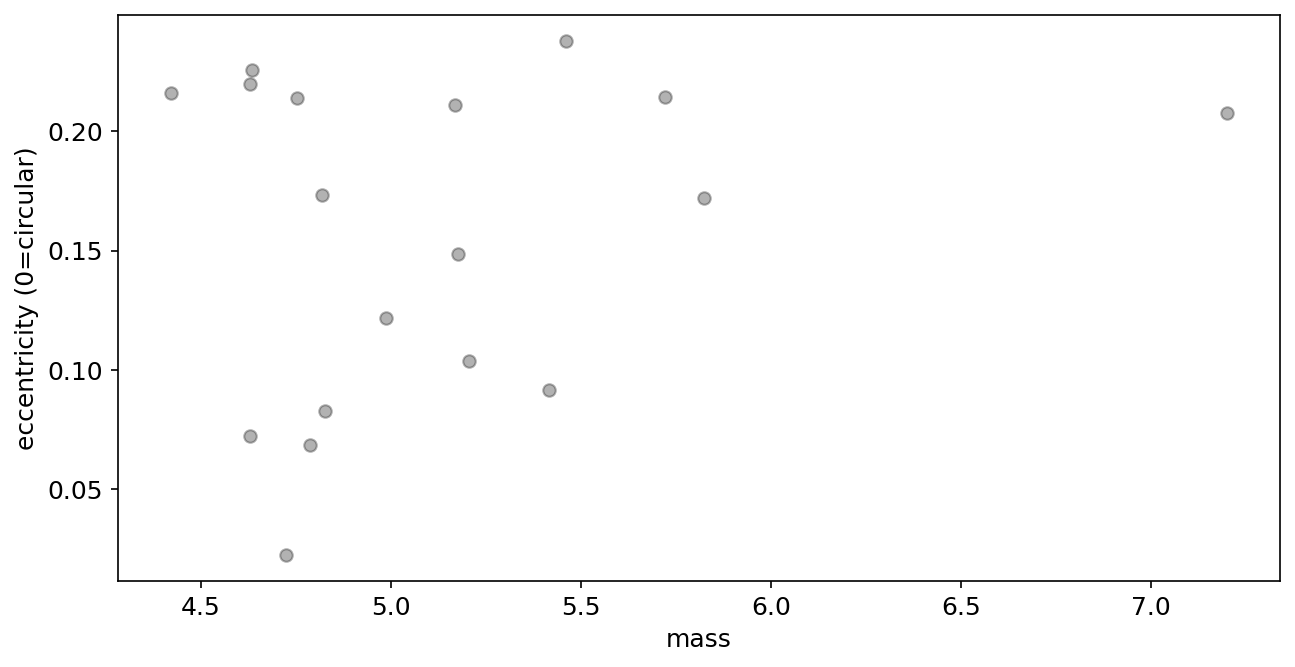

In [39]:
search_kws = {
    'search_range' : 35,
    'adaptive_stop' : 2.0,
    'adaptive_step' : 0.95,
}
t = tp.link(f, **search_kws)
plt.figure()
tp.mass_size(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass
tp.mass_ecc(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass

In [40]:
min_mass, max_mass = 4, 6
min_size, max_size = 1.8, 2.2
min_ecc, max_ecc = 0.1, 0.23
t1 = t[t['ecc'].between(min_ecc, max_ecc) &
       t['size'].between(min_size, max_size) & 
       t['mass'].between(min_mass, max_mass)]
t2 = tp.filter_stubs(t, 5)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t2['particle'].nunique())

Before: 18
After: 6


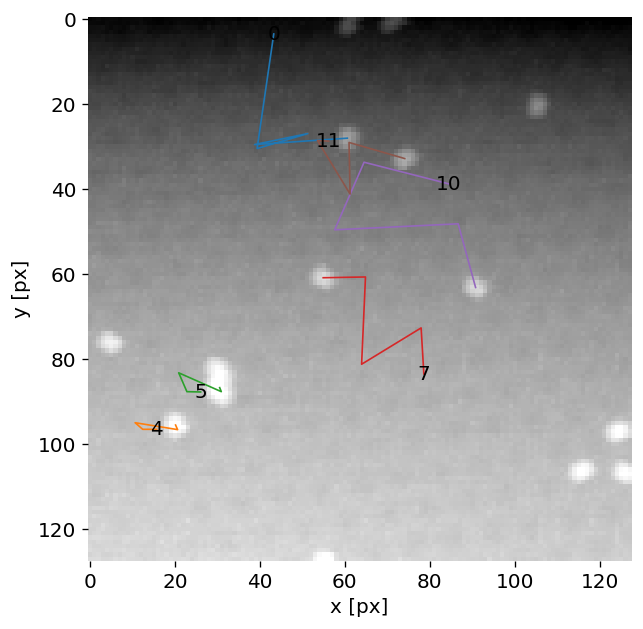

In [41]:
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig=plt.figure(figsize=(8, 6), dpi=120)
ax1=plt.axes(xlim=(0, 256), ylim=(0, 256), frameon=False)
plt.axis('off')
ln, = ax1.plot([], [], lw=3)
ax1.set_prop_cycle(color=['g', 'r', 'c', 'm', 'y', 'k'])
def animate(i):
    plt.cla()
    tp.plot_traj(t2[(t2['frame']<=i)], superimpose=frames[i], label=True, ax=ax1, plot_style={'alpha' : 1})
    ax1.set_prop_cycle(color=['g', 'r', 'c', 'm', 'y', 'k'])
#     plt.imshow(frames[i], cmap='gray')
# Set up formatting for the movie files
Writer = matplotlib.animation.writers['ffmpeg']
writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)
line_ani = matplotlib.animation.FuncAnimation(fig, animate, frames=5)
# line_ani.save('claymation.mp4', writer=writer)
line_ani

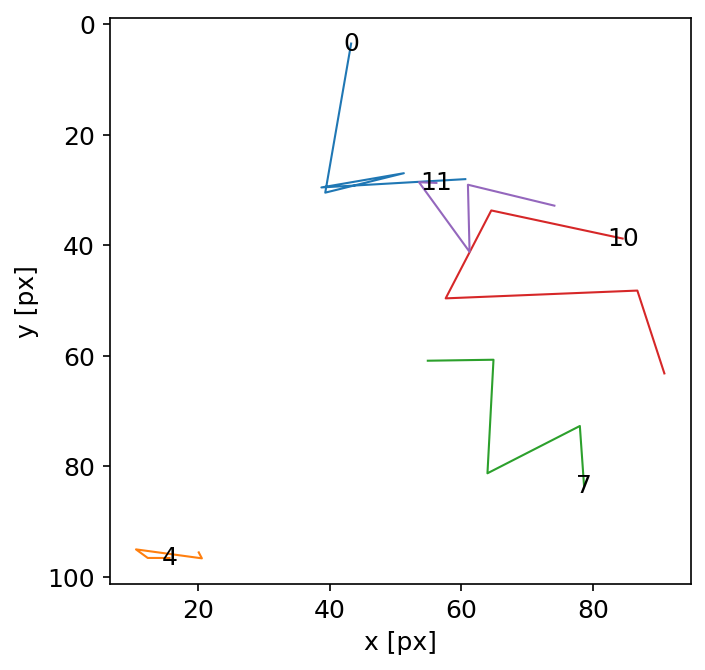

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
t2 = t2[~t2.particle.isin([5])] # 5 is a double molecule
tp.plot_traj(t2, label=True)

In [43]:
d = tp.compute_drift(t2)
t3 = tp.subtract_drift(t2.copy(), d)
t25 = t3.copy()

[7.954509579419566, 3.5847355059146806, 0.6017159400492135]


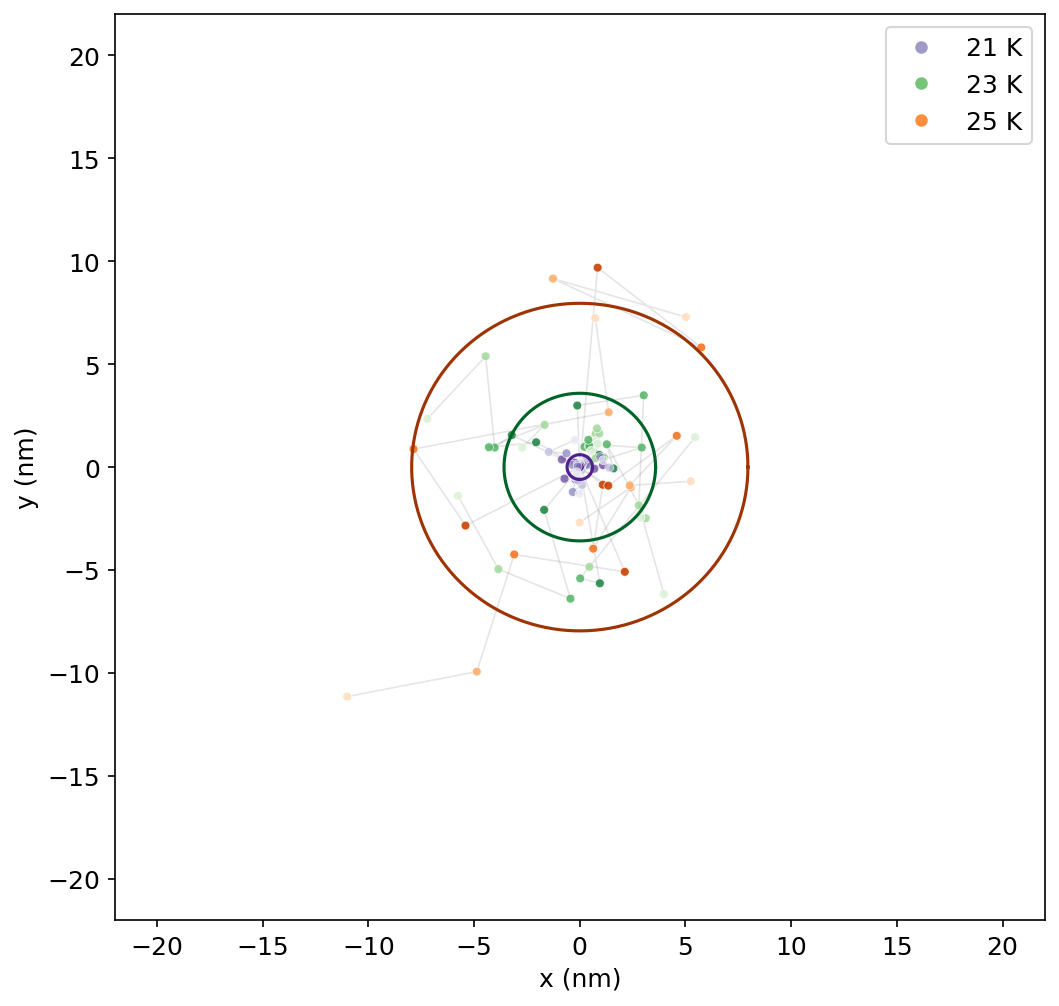

In [44]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}
import matplotlib
matplotlib.rc('font', **font)

def centered(df):
    df['x_centered'] = df['x'] - df['x'].iloc[0]
    df['y_centered'] = df['y'] - df['y'].iloc[0]
    df['t_centered'] = df['frame'] - df['frame'].iloc[0]
    df['msd'] = np.sqrt(df['x_centered'] **2 + df['y_centered'] ** 2)
    return df.head(20)
c = plt.cm.plasma(np.linspace(0.25, 0.75, 3))
fig, ax = plt.subplots(figsize=(8, 8))
# ax.axhline(0, lw=0.2, alpha=0.8)
# ax.axvline(0, lw=0.2, alpha=0.8)
for df, c, a in zip([t25, t23, t21], ['flare_r', 'light:seagreen_r', 'dark:#69d_r'], [0.9, 0.85, 0.5]):
    df = (df * 50 / 128).groupby('particle').apply(centered).reset_index(drop=True)
    for particle in df.particle.unique():
        tmp = df[df.particle == particle]
        ax.plot(tmp['x_centered'], tmp['y_centered'], alpha=0.1, lw=0.8, color='k', zorder=0)

msds = []
for df, c, a in zip([t25, t23, t21], ['Oranges_r', 'Greens_r', 'Purples_r'], [0.9, 0.85, 0.75]):
    df = (df * 50 / 128).groupby('particle').apply(centered).reset_index(drop=True)
    msds.append(df.groupby('particle').apply(lambda x : x.msd.iloc[-1]).mean())
    for particle in df.particle.unique():
        tmp = df[df.particle == particle]
        hue_norm = (0, tmp.t_centered.max() * 1.2)
        sns.scatterplot(x='x_centered', y='y_centered', size=1, data=tmp, hue='t_centered', hue_norm=hue_norm, palette=c, ax=ax, alpha=a, zorder=1)
#         break
#     break
print(msds)
for msd, c in zip(msds, ['Oranges_r', 'Greens_r', 'Purples_r']):
    angle = np.linspace( 0 , 2 * np.pi , 150 ) 
    c = sns.color_palette(c, as_cmap=True)(0.1)
    radius = msd

    x = radius * np.cos( angle ) 
    y = radius * np.sin( angle )
    ax.plot( x, y, c=c ) 
ax.get_legend().remove()

import matplotlib.lines as mlines
c = ['Oranges_r', 'Greens_r', 'Purples_r']
purple = mlines.Line2D([], [], color=sns.color_palette(c[0], as_cmap=True)(0.5), marker='o', linestyle='None',
                          markersize=5, label='25 K')

green = mlines.Line2D([], [], color=sns.color_palette(c[1], as_cmap=True)(0.5), marker='o', linestyle='None',
                          markersize=5, label='23 K')

orange = mlines.Line2D([], [], color=sns.color_palette(c[2], as_cmap=True)(0.5), marker='o', linestyle='None',
                          markersize=5, label='21 K')

plt.legend(handles=[orange, green, purple])

ax.set_xlabel('x (nm)')
ax.set_ylabel('y (nm)')
ax.set_xlim(-22, 22)
ax.set_ylim(-22, 22)
plt.savefig('exp_traj.svg')

/home/a/as/asai/dsgo/trading/trading/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/a/as/asai/dsgo/trading/trading/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in sqrt
/home/a/as/asai/dsgo/trading/trading/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/a/as/asai/dsgo/trading/trading/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in sqrt


5
11


/home/a/as/asai/dsgo/trading/trading/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/a/as/asai/dsgo/trading/trading/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in sqrt


10
[0.08415215 0.32934212] [[0.35808893        nan]
 [       nan 0.34263092]] 82.35187734310742
[0.08415215 0.32934212] [[0.35808893        nan]
 [       nan 0.34263092]] 19.006042056587937
[0.08415215 0.32934212] [[0.35808893        nan]
 [       nan 0.34263092]] 0.5678570812880512


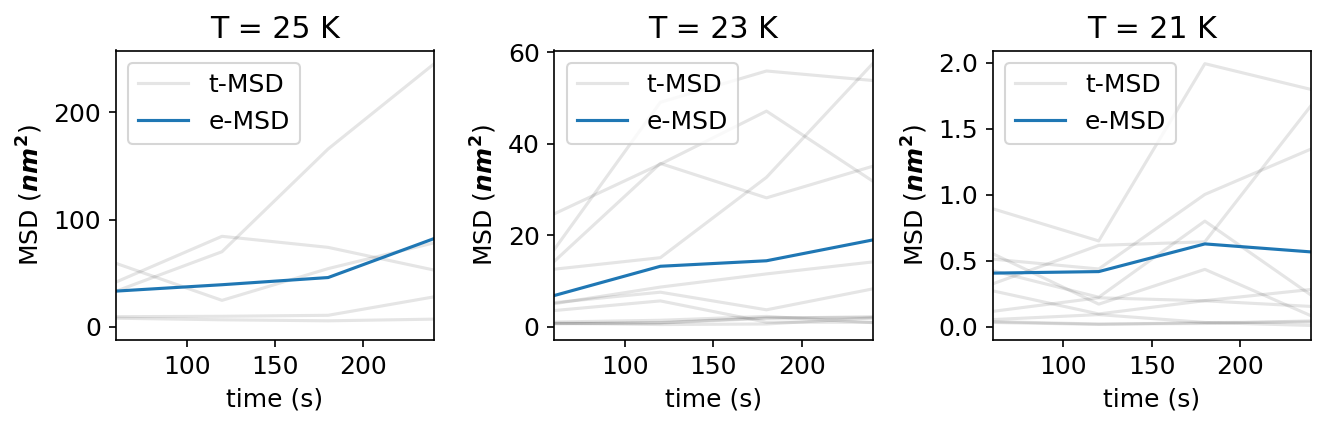

In [51]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
voltages = [25, 23, 21]
from scipy.optimize import curve_fit
ps, covs, last = [], [], []
f = lambda x, a, b : a * x + b
for i, df in enumerate([t25, t23, t21]):
    df = df.groupby('particle').apply(centered).reset_index(drop=True)
    im = tp.imsd(df, frames.meters_per_pixel * 1e6, 1/60, max_lagtime=5) * 1e6
    ax[i].plot(im.index, im , 'k-', alpha=0.1)  # black lines, semitransparent
    ax[i].plot([1e-9], [1e-9], 'k-', alpha=0.1, label='t-MSD')
    df = df * 50 / 128
#     for p in df['particle'].unique():
#         tmp = df[df.particle == p]
#         ax[i].plot(tmp['t_centered'] * 128 / 50 * 15, tmp['msd'], color='k', alpha=0.2)
    df['msd'] = df['msd'] ** 2
    emsd = df.groupby('t_centered')['msd'].mean().reset_index(drop=True)
    ax[i].plot(df.t_centered.unique() * 128 / 50 * 60, emsd, label='e-MSD')
    last.append(emsd.iloc[-1])
    df['msd'] = np.log(df['msd'])
    df['t_centered'] = np.log(df['t_centered'])
    tmp = tmp.replace([np.inf, -np.inf], np.nan, inplace=False).dropna(subset=["t_centered", "msd"], how="any")
    popt, popcov = curve_fit(f, tmp['t_centered'], tmp['msd'])
    ps.append(popt)
    print(len(df.particle.unique()))
    covs.append(np.sqrt(popcov))
    ax[i].set_title("T = " + "{} K".format(voltages[i]))
    ax[i].set_ylabel('MSD ($nm^2$)')
    ax[i].set_xlabel('time (s)')
    ax[i].set_xscale('linear')
    ax[i].set_yscale('linear')
    ax[i].legend()
    ax[i].set_xlim(60, 240)
#     ax[i].set_ylim(1e-1, 3e2)
    x = np.linspace(0, 100, 2)
    y = 1e-2 * x
#     if i == 0: ax[i].plot(x, y, '--')
#     break
fig.tight_layout()
for p, c, l in zip(ps, covs, last):
    print(p, c, l)

In [49]:
last

[82.35187734310742, 19.006042056587937, 0.5678570812880512]